In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import random, lax, vmap
import jax

plt.rcParams.update({'font.size': 14})
print(jax.local_device_count())
print(jax.devices()[0])

1
gpu:0


In [2]:
# 2 layer NN constructor
def construct_NN(N, D, key):
    return [random.normal( random.fold_in(key, 1), (N,)), random.normal(random.fold_in(key, 3), (N,D))]

# online training for 2 layer linear network
def online_training_linear(eta, gamma, D=10, N =100, E=1000, T=250):
    
    beta_star = np.zeros(D)
    beta_star[0] = 1
    
    def update_fn(ss, t):
        params, params0 = ss
        a0,W0 = params0
        a, W = params
        #beta = 1/N * (W.T @ a - W0.T @ a0) / gamma 
        beta = 1/N * W.T @ a / gamma
        da = gamma * eta * W @ (beta_star - beta) 
        dW = gamma * eta * jnp.outer(a, beta_star-beta) 
        single_dim = beta_star[0] - beta[0]
        loss = jnp.sqrt( jnp.sum((beta_star-beta)**2) )
        W_beta = W @ beta_star
        M_beta = 1/N * jnp.dot(W_beta,W_beta) + jnp.mean(a**2)*jnp.sum(beta_star**2)
        #kernel_align = 
        return [[[a+da, W+dW], params0], [loss, single_dim, beta_star - beta]]
    
    def init_fully(seed, N):
        params = construct_NN(N, D, random.PRNGKey(seed))
        return [params,params]
    
    train = lambda ss0: lax.scan(update_fn, ss0, jnp.array(range(T)))

    ss_mapped = vmap(init_fully, (0,None))(jnp.arange(1, E, step = 1, dtype=jnp.int32), N) # initialize E networks
    states_f, losses_align = vmap(train)(ss_mapped) # train w/ vectorization
    loss, single_dim, delta = losses_align
    return loss, single_dim, delta


# offline training with whitened data. There are P data. When P is close to N
def offline_training_linear(eta, gamma, P=10, N =100, E=1000, T=250):   
    
    y = np.zeros(P)
    y[0] = 1
    X, _ = jnp.linalg.qr( random.normal(random.PRNGKey(0), (P,P) ) )
    
    def update_fn(ss, t):
        params, params0 = ss
        a0, W0 = params0
        a, W = params
        #beta = 1/N * (W.T @ a - W0.T @ a0) / gamma 
        h = W @ X
        f = 1/N * h.T @ a / gamma 
        da = gamma * eta * h @ (y - f) 
        dW = gamma * eta * jnp.outer(a, X @ (y-f) ) 
        single_dim = y[0] - f[0]
        loss = jnp.sqrt( jnp.sum((y - f)**2) )
        #W_beta = W @ beta_star
        #M_beta = 1/N * jnp.dot(W_beta,W_beta) + jnp.mean(a**2)*jnp.sum(beta_star**2)
        #kernel_align = 
        return [[[a+da, W+dW], params0], [loss, single_dim, y - f]]
    
    def init_fully(seed, N):
        params = construct_NN(N, P, random.PRNGKey(seed))
        return [params,params]
    
    train = lambda ss0: lax.scan(update_fn, ss0, jnp.array(range(T)))

    ss_mapped = vmap(init_fully, (0,None))(jnp.arange(1, E, step = 1, dtype=jnp.int32), N) # initialize E networks
    states_f, losses_align = vmap(train)(ss_mapped) # train w/ vectorization
    loss, single_dim, delta = losses_align
    return loss, single_dim, delta


def linear_dmft(eta, gamma, T, iter = 12, up_speed =0.25):
    eta_gam = eta * gamma
    betas = np.zeros(T)
    ms = np.zeros(T)
    beta = 0.0
    m = 2.0
    
    for t in range(T):
        betas[t] = beta
        ms[t] = m
        db = eta * m * (1-beta)
        dm = 4 * eta * gamma**2 * beta*(1-beta)
        beta += db
        m += dm
    Deltas = 1.0 - betas
    return Deltas


# compute finite size dynamical effect
def linear_dmft_fluctuations(eta, gamma, T, Delta, y = 1.0):

    # compute H(t,s), G(t,s) , R(t,s)
    eta_gam = eta * gamma
    tril_low = jnp.tril(jnp.ones((T,T)), k=-1) # for causal integration
    V = eta_gam * jnp.einsum('ij,j->ij', tril_low, Delta)
    M = V @ V
    # h = (I - M)^{-1} [u 1 + r v], where v(t) = \int_0^t Delta(s) ds
    v = jnp.einsum('ij->i', V) # compute V @ 1
  
    # h = u a + b * r
    a = jnp.linalg.solve( jnp.eye(T) - M, jnp.ones(T) ) 
    b = jnp.linalg.solve( jnp.eye(T) - M, v)
    # H(t,s) kernel
    H = jnp.outer(a,a) + jnp.outer(b,b)
    K = 2.0 * H
    # R(t,s) = < h(t) z(s) > = (I-M)^{-1}[ gamma *1 v^T + gamma*v 1^T  ]  (I - M)^{-1}
    R = jnp.outer(a,b) + jnp.outer(b,a)
  
    # compute 4th cumulant kappa(t,s) 
    kappa = 4 * H**2 + 4 * R**2     # this is the variance along the beta_star projection
  
    # compute D(t,s) = < d K(t) / d Delta(s) >
    # below is computed with grad flow approximation 
    #D = 4 * eta**2 * gamma**2 * jnp.einsum('ij,j->ij', tril_low, y - 2 * Delta )
    D = 2 * eta_gam * jnp.einsum('i,ij->ij', jnp.exp(2*v) - jnp.exp(-2*v), tril_low)

    # populate entries in matrix  d/dhat{q}(t) dq(s) S 
    Hess_off = np.zeros((2*T,2*T))
    Hess_off[0:T,0:T] = jnp.eye(T) + eta*jnp.einsum('ij,j->ij', tril_low, jnp.diag(K) ) # derivative wrt hat{Delta} and Delta 
    Hess_off[0:T,T:] = eta * jnp.einsum('ij,j->ij', tril_low, Delta)
    Hess_off[T:,0:T] = -1.0 *  D
    Hess_off[T:,T:] = jnp.eye(T)

    block_kappa = np.zeros((2*T,2*T))
    block_kappa[T:,T:] = kappa

    inv_off = jnp.linalg.inv(Hess_off + 1e-2*jnp.eye(2*T))  
    cov_full = inv_off @ block_kappa @ inv_off.T

    Delta_var = cov_full[:T,:T]
    K_var = cov_full[T:,T:]

    return H, kappa, Delta_var, K_var


def solve_catapult_DMFT_fluctuation(eta, gamma, T = 100):

    # first solve for Delta with DMFT equations

    f = 0.0
    y = 1.0
    K = 2.0
    ft = np.zeros(T)
    Kt = np.zeros(T)
    for t in range(T):
        ft[t] = f
        Kt[t] = K
        df = eta * K * (y - f) + eta**2 * gamma**2 * f * (y-f)**2
        dK = 4 * eta * gamma**2 * f * (y-f) + eta**2 * gamma**2 * (y-f)**2 * K
        f = f + df
        K = K + dK

    Delta = y - ft
    Theta = jnp.tril(jnp.ones((T,T)), k = -1)
    Theta_Delta = jnp.einsum('ij,j->ij', Theta, Delta)
    vp = jnp.linalg.solve( jnp.eye(T) - eta * gamma * Theta_Delta, jnp.ones(T) )
    vm = jnp.linalg.solve( jnp.eye(T) + eta * gamma * Theta_Delta, jnp.ones(T) )

    Theta_Delta_inv_Theta_p = jnp.linalg.inv( jnp.eye(T) - eta * gamma * Theta_Delta ) @ Theta
    Theta_Delta_inv_Theta_m = jnp.linalg.inv( jnp.eye(T) + eta * gamma * Theta_Delta ) @ Theta  

    kappa_f = 0.25* ( jnp.outer(vp,vp) + jnp.outer(vm,vm) )**2 + 0.25*( jnp.outer(vp,vp) - jnp.outer(vm,vm) )**2
    
    D = eta * gamma * Theta_Delta_inv_Theta_p * jnp.outer(vp,vp) + eta * gamma * Theta_Delta_inv_Theta_m * jnp.outer(vm,vm)

    D_K = 2*eta * gamma * Theta_Delta_inv_Theta_p * jnp.outer(vp,vp) - 2*eta * gamma * Theta_Delta_inv_Theta_m * jnp.outer(vm,vm)

    kappa_fK = (jnp.outer(vp,vp) + jnp.outer(vm,vm)) * (jnp.outer(vp,vp) - jnp.outer(vm,vm))
    kappa_K = (jnp.outer(vp,vp) + jnp.outer(vm,vm))**2 + (jnp.outer(vp,vp) - jnp.outer(vm,vm))**2
    
    #kappa_diag = 0.5 * jnp.outer(vp,vp) + 0.5 * jnp.outer(vm,vm)
    #D_id = - eta * gamma * Theta - eta*gamma*Theta * kappa_diag
    #var_diag = jnp.linalg.inv(jnp.eye(T) - D_id) @ kappa_diag @ jnp.linalg.inv(jnp.eye(T) - D_id).T
    
    # now trying to get the D_{perp}(t,s) function
    aa_corr = 0.5 * jnp.outer(vp,vp) + 0.5 * jnp.outer(vm,vm)
    da_dDelta = jnp.linalg.inv(jnp.eye(T) - eta**2 * gamma**2 * Theta_Delta @ Theta_Delta)
    D_perp = eta * gamma * Theta * aa_corr + eta * gamma * da_dDelta @ Theta
    
    # compute the perpindicular < a(t) h_mu(t) a(s) h_\mu(s) > 
    #kappa_perp = 
    Sigma_perp = jnp.linalg.inv(gamma*jnp.eye(T) + D_perp) @ aa_corr @ jnp.linalg.inv(gamma*jnp.eye(T) + D_perp).T
    
    # now promote to 4*T x 4*T for variables (f, K, hat{f}, hat{K})
    H = np.zeros((4*T, 4*T))
    H[2*T:3*T,0:T] = gamma * np.eye(T) + D # d/d(hat{f} df
    H[0:T,2*T:3*T] = gamma * np.eye(T) + D.T # d/df d/dhat{f}
  
    H[3*T:,0:T] = D_K # d/dhat{K} d/f
    H[0:T,3*T:] = D_K.T # d/d{hat f} d/d K
  
    H[T:2*T,3*T:] = np.eye(T) # d/dK d/dhat{K}
    H[3*T:,T:2*T] = np.eye(T) # d/dhat{K} d/d

    # now enter all kappa blocks
    H[2*T:3*T,2*T:3*T] = kappa_f #
    H[2*T:3*T,3*T:] = kappa_fK
    H[3*T:,2*T:3*T] = kappa_fK.T 
    H[3*T:,3*T:] = kappa_K
  
    prop = jnp.linalg.inv(H)
    Sigma_Delta = - prop[0:T,0:T]
    Sigma_K = -prop[T:2*T,T:2*T]
    return Delta, Kt, jnp.diag(Sigma_Delta), jnp.diag(Sigma_K), jnp.diag(Sigma_perp)

In [3]:
eta = 0.002
gamma = 4.0
N = 400
T = 500
D = 100
loss, single_dim, delta = online_training_linear(eta, gamma, D=D, N =N , E=1000, T=T)
#Deltas = linear_dmft(eta, gamma, T=T)
Deltas, Kt, Sigma_Delta, Sigma_K, diag_kappa = solve_catapult_DMFT_fluctuation(eta, gamma, T = T)

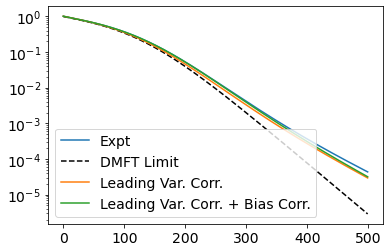

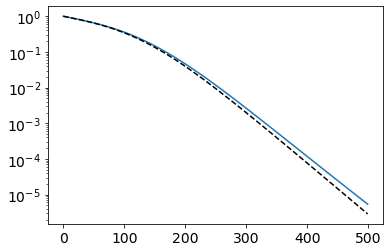

(999, 500, 100)


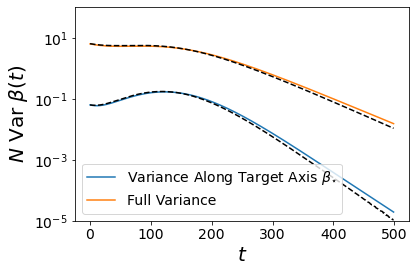

(999, 500, 100)


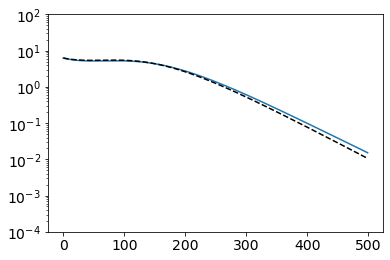

In [4]:

#plt.semilogy((loss**2).mean(axis = 0))
plt.semilogy( jnp.mean( delta**2, axis = 0).sum(axis=-1), label = 'Expt')
plt.semilogy(Deltas**2, '--', color = 'black', label = 'DMFT Limit')
plt.semilogy(Deltas**2 + 1/N * Sigma_Delta + (D-1)/N * diag_kappa, label = 'Leading Var. Corr.')
plt.semilogy(Deltas**2 +  2*(delta[:,:,0].mean(axis=0) - Deltas)*Deltas + 1/N*Sigma_Delta + D/N * diag_kappa, label = 'Leading Var. Corr. + Bias Corr.')
plt.legend()
plt.show()

#plt.plot(aligns.mean(axis= 0))
#plt.show()
#plt.semilogy(single_dim.mean(axis = 0))
#plt.show()

plt.semilogy( jnp.sum(delta.mean(axis = 0)**2, axis = -1) )
# Delta_infty^2 + 2 < Delta - Delta_infty> Delta_infty + Sigma_{Delta}
plt.semilogy(Deltas**2 ,  '--', color = 'black')
plt.show()


print(delta.shape)
# Sigma_Delta correctly computes error along first axis
# however there is also errors on other axes of beta


plt.plot( N * delta[:,:,0].var(axis = 0) , label = r'Variance Along Target Axis $\beta_{\star}$')
plt.plot( N * delta.var(axis = 0).sum(axis=-1), label = 'Full Variance')
#plt.plot(N * Delta)
plt.semilogy(Sigma_Delta, '--', color = 'black')
plt.semilogy(D * diag_kappa + Sigma_Delta, '--', color = 'black')
plt.xlabel(r'$t$', fontsize =20)
plt.ylabel(r'$N$ Var $\beta(t)$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.ylim([1e-5,1e2])
plt.savefig('figures/var_targetaxis_vs_nontarget_online.pdf')
plt.show()


print(delta.shape)
#plt.plot(N * Delta)
plt.plot( N * delta.var(axis = 0).sum(axis=-1) )
plt.semilogy((D-1) * diag_kappa + Sigma_Delta, '--', color = 'black')
plt.ylim([1e-4,1e2])

plt.show()

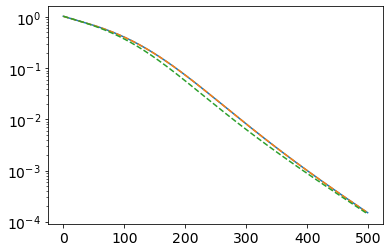

In [8]:
plt.semilogy( jnp.mean(delta**2, axis = 0).sum(axis = -1)  )
plt.semilogy( jnp.sum( jnp.mean(delta, axis = 0)**2, axis = -1) + delta.var(axis = 0).sum(axis=-1) ,'--' )
plt.semilogy( Deltas**2 + delta.var(axis = 0).sum(axis=-1) ,'--' )
plt.show()

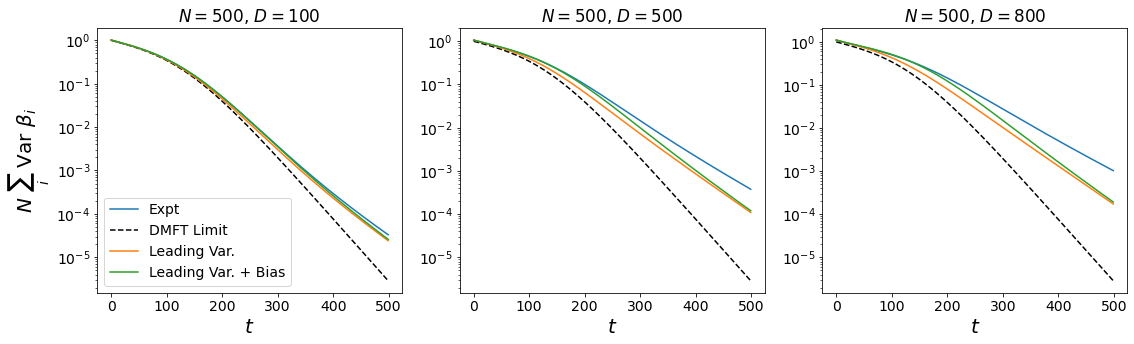

In [12]:
N = 500
Dvals = [100,500, 800]
plt.figure(figsize = (16,5))
for i, D in enumerate(Dvals):
    plt.subplot(1,len(Dvals), i+1)
    loss, single_dim, delta = online_training_linear(eta, gamma, D=D, N =N , E=1000, T=T)
    #Deltas = linear_dmft(eta, gamma, T=T)
    #Deltas, Kt, Sigma_Delta, Sigma_K, diag_kappa = solve_catapult_DMFT_fluctuation(eta, gamma, T = T)
    
    plt.semilogy( jnp.mean( delta**2, axis = 0).sum(axis=-1), label = 'Expt')
    plt.semilogy(Deltas**2, '--', color = 'black', label = 'DMFT Limit')
    plt.semilogy(Deltas**2 + 1/N * Sigma_Delta + (D-1)/N * diag_kappa, label = 'Leading Var.')
    plt.semilogy(Deltas**2 +  2*(delta[:,:,0].mean(axis=0) - Deltas)*Deltas + 1/N*Sigma_Delta + D/N * diag_kappa, label = 'Leading Var. + Bias')
    if i == 0:
        plt.legend()
        plt.ylabel(r'$N$ $\sum_i$ Var $\beta_i$', fontsize=20)
    #plt.semilogy(Sigma_Delta, '--', color = 'black')
    plt.xlabel(r'$t$', fontsize = 20)
    plt.title(r'$N = %d$, $D = %d$' % (N,D))
#plt.legend()
plt.tight_layout()
plt.savefig('figures/bias_vs_variance_contribution.pdf')
plt.show()

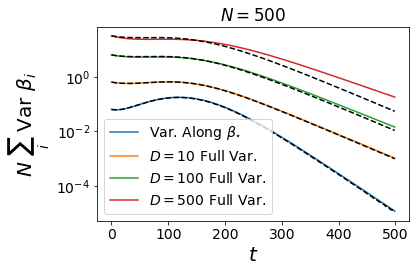

In [56]:
N = 500
Dvals = [10, 100, 500]

for i, D in enumerate(Dvals):
    loss, single_dim, delta = online_training_linear(eta, gamma, D=D, N =N , E=1000, T=T)
    #Deltas = linear_dmft(eta, gamma, T=T)
    #Deltas, Kt, Sigma_Delta, Sigma_K, diag_kappa = solve_catapult_DMFT_fluctuation(eta, gamma, T = T)
    if i == 0:
        plt.plot( N * delta[:,:,0].var(axis = 0) , label = r'Var. Along $\beta_{\star}$')
    plt.plot( N * delta.var(axis = 0).sum(axis=-1), label = r'$D = %d$ Full Var.' % D)
    plt.semilogy((D-1) * diag_kappa + Sigma_Delta, '--', color = 'black')
plt.semilogy(Sigma_Delta, '--', color = 'black')
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$N$ $\sum_i$ Var $\beta_i$', fontsize=20)
plt.title(r'$N = %d$' % N)
plt.legend()
plt.tight_layout()
plt.savefig('figures/var_targetaxis_vs_nontarget_online_vs_D.pdf')
plt.show()

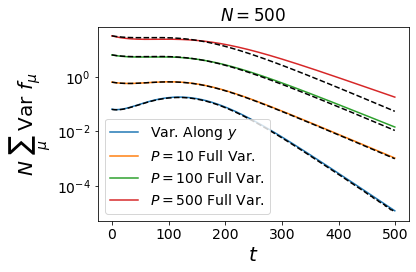

In [57]:
Pvals = [10, 100, 500]
N = 500
for i, P in enumerate(Pvals):
    loss, single_dim, delta = offline_training_linear(eta, gamma, P=P, N =N , E=1000, T=T)
    #Deltas = linear_dmft(eta, gamma, T=T)
    #Deltas, Kt, Sigma_Delta, Sigma_K, diag_kappa = solve_catapult_DMFT_fluctuation(eta, gamma, T = T)
    if i == 0:
        plt.plot( N * delta[:,:,0].var(axis = 0) , label = r'Var. Along $y$')
    plt.plot( N * delta.var(axis = 0).sum(axis=-1), label = r'$P = %d$ Full Var.' % P)
    plt.semilogy((P-1) * diag_kappa + Sigma_Delta, '--', color = 'black')
plt.semilogy(Sigma_Delta, '--', color = 'black')
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$N$ $\sum_{\mu}$ Var $f_\mu$', fontsize=20)
plt.title(r'$N = %d$' % N)
plt.legend()
plt.tight_layout()
plt.savefig('figures/var_targetaxis_vs_nontarget_offline_vs_P.pdf')
plt.show()

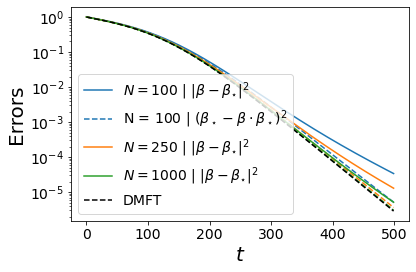

In [58]:
Nvals = [100, 250, 1000]
for i, N in enumerate(Nvals):
    loss, single_err, aligns = online_training_linear(eta, gamma, D=20, N =N , E=1000, T=500)
    #plt.plot(loss.mean(axis = 0)**2)
    plt.semilogy((loss**2).mean(axis =0), label = r'$N = %d$ | $|\beta- \beta_{\star}|^2$' % N)
    if i == 0:
        plt.semilogy( (single_err**2).mean(axis=0), '--', color = f'C{i}', label = r'N = %d | $(\beta_\star - \beta \cdot \beta_\star)^2$' % N)
    else:
        plt.semilogy( (single_err**2).mean(axis=0), '--', color = f'C{i}')

plt.semilogy(Deltas**2, '--', color = 'black', label = 'DMFT')
plt.xlabel(r'$t$', fontsize =20)
plt.ylabel(r'Errors',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.show()

#plt.plot(N * loss.var(axis = 0))

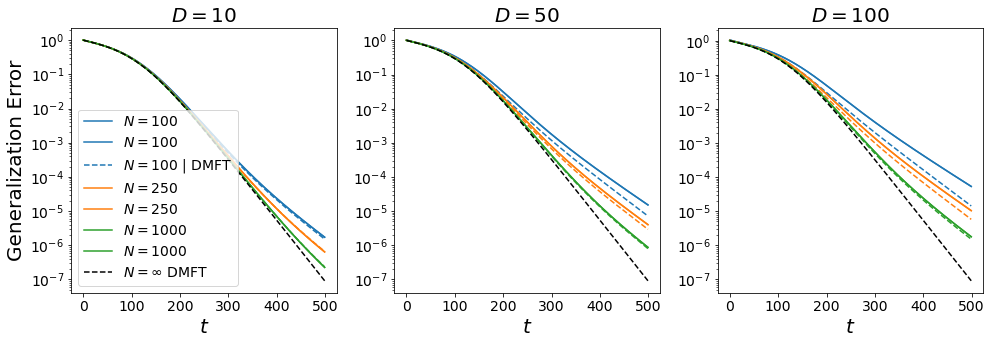

In [70]:
Nvals = [100, 250, 1000]
Dvals = [10,50,100]
plt.figure(figsize = (14,5))
for j,D in enumerate(Dvals):
    plt.subplot(1,len(Dvals), j+1)
    plt.title(f'$D = {D}$',fontsize = 20)
    for i, N in enumerate(Nvals):
        loss, single_err, delta = online_training_linear(eta, gamma, D=D, N =N , E=1000, T=500)
        gen_err_expt = jnp.sum( delta**2 , axis = -1).mean(axis = 0)
        plt.semilogy(gen_err_expt, label = r'$N = %d$' % N, color = f'C{i}')
        #plt.plot(loss.mean(axis = 0)**2)
        plt.semilogy((loss**2).mean(axis =0), label = f'$N = {N}$', color = f'C{i}')
        #plt.semilogy( (loss).mean(axis=0)**2,label = f'$N = {N}$', color = f'C{i}')
        if i == 0:
            plt.semilogy( Deltas**2 + 1.0/N * (D * diag_kappa + Sigma_Delta), '--', label=f'$N={N}$ | DMFT', color = f'C{i}')
        else:
            plt.semilogy( Deltas**2 + 1.0/N * (D * diag_kappa + Sigma_Delta), '--', color = f'C{i}')
    plt.plot(Deltas**2, '--', color = 'black', label = '$N = \infty$ DMFT')
    plt.xlabel(r'$t$', fontsize =20)
    if j == 0:
        plt.ylabel(r'Generalization Error',fontsize = 20)
        plt.legend()
    plt.tight_layout()
plt.savefig('figures/leading_N_correction_online_gen_vs_N.pdf')
plt.show()

## plot for multiple dimensions... 
## plot for multiple gamma!


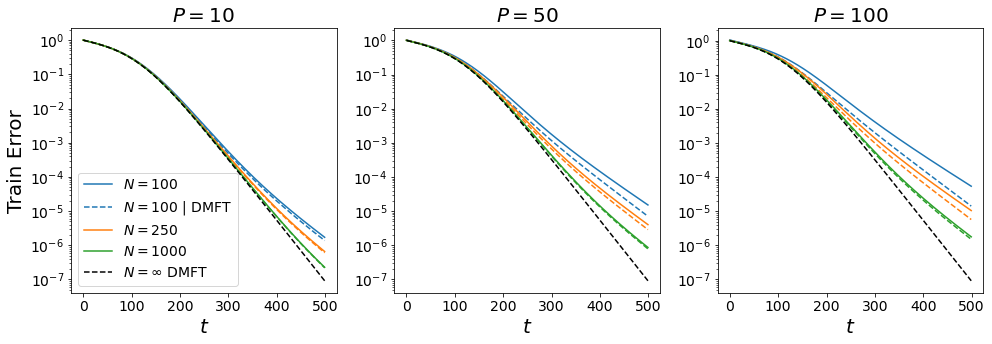

In [71]:
Nvals = [100, 250, 1000]
Pvals = [10,50,100]
plt.figure(figsize = (14,5))
for j,P in enumerate(Pvals):
    plt.subplot(1,len(Pvals), j+1)
    plt.title(f'$P = {P}$',fontsize = 20)
    for i, N in enumerate(Nvals):
        loss, single_err, delta = offline_training_linear(eta, gamma, P=P, N =N , E=1000, T=500)
        #plt.plot(loss.mean(axis = 0)**2)
        gen_err_expt = jnp.sum( delta**2 , axis = -1).mean(axis = 0)
        plt.semilogy(gen_err_expt, label = r'$N = %d$' % N, color = f'C{i}')
        #plt.semilogy((loss**2).mean(axis =0), label = f'$N = {N}$', color = f'C{i}')
        #plt.semilogy( (loss).mean(axis=0)**2,label = f'$N = {N}$', color = f'C{i}')
        if i == 0:
            plt.semilogy( Deltas**2 + 1.0/N * ((P-1) * diag_kappa + Sigma_Delta), '--', label=f'$N={N}$ | DMFT', color = f'C{i}')
        else:
            plt.semilogy( Deltas**2 + 1.0/N * ((P-1) * diag_kappa + Sigma_Delta), '--', color = f'C{i}')
    plt.plot(Deltas**2, '--', color = 'black', label = '$N = \infty$ DMFT')
    plt.xlabel(r'$t$', fontsize =20)
    if j == 0:
        plt.ylabel(r'Train Error',fontsize = 20)
        plt.legend()
    plt.tight_layout()
plt.savefig('figures/leading_N_correction_offline_gen_vs_N.pdf')
plt.show()

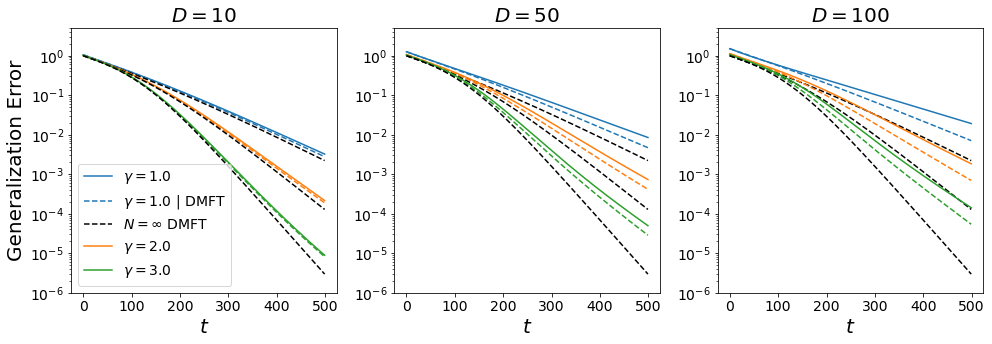

In [106]:
N = 200
gamma_vals = [1.0,2.0,3.0]
Dvals = [10,50,100]
eta = 0.0025

plt.figure(figsize = (14,5))
for j,D in enumerate(Dvals):
    plt.subplot(1,len(Dvals), j+1)
    plt.title(f'$D = {D}$',fontsize = 20)
    for i, gamma in enumerate(gamma_vals):
        loss, single_err, delta = online_training_linear(eta, gamma, D=D, N =N , E=1000, T=500)
        Deltas, Kt, Sigma_Delta, Sigma_K, diag_kappa = solve_catapult_DMFT_fluctuation(eta, gamma, T = T)
        #plt.plot(loss.mean(axis = 0)**2)
        gen_err_expt = jnp.sum( delta**2 , axis = -1).mean(axis = 0)
        plt.semilogy(gen_err_expt, label = f'$\gamma = {gamma}$')
        #plt.semilogy( (loss).mean(axis=0)**2,label = f'$\gamma = {gamma}$', color = f'C{i}')
        if i == 0:
            plt.semilogy( Deltas**2 + 1.0/N * (D * diag_kappa + Sigma_Delta), '--', label=f'$\gamma={gamma}$ | DMFT', color = f'C{i}')
        else:
            plt.semilogy( Deltas**2 + 1.0/N * (D * diag_kappa + Sigma_Delta), '--', color = f'C{i}')
        if i == 0 and j ==0:
            plt.plot(Deltas**2, '--', color = 'black', label = '$N = \infty$ DMFT')
        else:
            plt.plot(Deltas**2, '--', color = 'black')

    plt.xlabel(r'$t$', fontsize =20)
    if j == 0:
        plt.ylabel(r'Generalization Error',fontsize = 20)
        plt.legend()
    plt.tight_layout()
    plt.ylim([1e-6,5.0])

plt.savefig('figures/leading_N_correction_online_gen_vs_gamma.pdf')
plt.show()

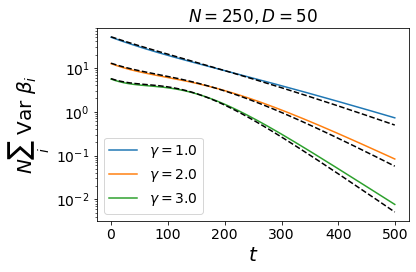

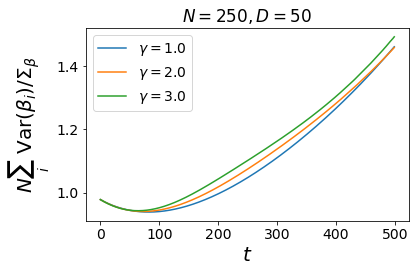

In [108]:
D = 50
N = 250
#plt.figure(figsize = (8,6))
for i, gamma in enumerate(gamma_vals):
    loss, single_err, delta = online_training_linear(eta, gamma, D=D, N =N , E=1000, T=500)
    Deltas, Kt, Sigma_Delta, Sigma_K, diag_kappa = solve_catapult_DMFT_fluctuation(eta, gamma, T = T)
    #Noise_to_signal_dmft = ( D * diag_kappa + Sigma_Delta ) / Deltas**2
    #Noise_to_signal_expt = N * delta.var(axis = 0).sum(axis=-1) /  jnp.sum( delta.mean(axis = 0)**2, axis = -1) 
    Noise_dmft = D * diag_kappa + Sigma_Delta 
    Noise_expt = N * delta.var(axis = 0).sum(axis=-1)
    plt.semilogy(Noise_expt, label = f'$\gamma = {gamma}$', color = f'C{i}')
    plt.semilogy(Noise_dmft, '--', color = f'black')
    #plt.semilogy(Noise_to_signal_expt, label = f'$\gamma = {gamma}$', color = f'C{i}')
    #plt.semilogy(Noise_to_signal_dmft, '--', color = f'black')
plt.legend()
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$N \sum_{i}$ Var $\beta_i$', fontsize = 20)
plt.title(r'$N = %d, D=%d$' % (N,D))
plt.tight_layout()
plt.savefig('figures/noise_vs_gamma_online.pdf')
plt.show()

D = 50
N = 250
#plt.figure(figsize = (8,6))
for i, gamma in enumerate(gamma_vals):
    loss, single_err, delta = online_training_linear(eta, gamma, D=D, N =N , E=1000, T=500)
    Deltas, Kt, Sigma_Delta, Sigma_K, diag_kappa = solve_catapult_DMFT_fluctuation(eta, gamma, T = T)
    #Noise_to_signal_dmft = ( D * diag_kappa + Sigma_Delta ) / Deltas**2
    #Noise_to_signal_expt = N * delta.var(axis = 0).sum(axis=-1) /  jnp.sum( delta.mean(axis = 0)**2, axis = -1) 
    Noise_dmft = D * diag_kappa + Sigma_Delta 
    Noise_expt = N * delta.var(axis = 0).sum(axis=-1)
    plt.plot(Noise_expt / Noise_dmft, label = f'$\gamma = {gamma}$', color = f'C{i}')
    #plt.semilogy(Noise_dmft, '--', color = f'black')
    #plt.semilogy(Noise_to_signal_expt, label = f'$\gamma = {gamma}$', color = f'C{i}')
    #plt.semilogy(Noise_to_signal_dmft, '--', color = f'black')
plt.legend()
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel(r'$N \sum_{i}$ Var$(\beta_i) / \Sigma_{\beta}$', fontsize = 20)
plt.title(r'$N = %d, D=%d$' % (N,D))
plt.tight_layout()
plt.savefig('figures/noise_vs_gamma_online.pdf')
plt.show()

In [172]:
for i, N in enumerate(Nvals):
    loss, aligns = online_training_linear(eta, gamma, D=2, N =N , E=1000, T=500)
    plt.semilogy(loss.mean(axis = 0))
    #plt.plot((loss**2).mean(axis =0))
plt.show()

ValueError: too many values to unpack (expected 2)

In [ ]:
def DMFT_action_beta(order_params, eta, gamma, beta_star):
    
    # beta is T x D 
    beta, beta_hat = order_params
    T = beta.shape[0]
    D = beta.shape[1]
    
    delt = beta_star[jnp.newaxis,:] - beta # T x D
    Theta = eta * jnp.tril(jnp.ones((T,T)),k=-1)
    # compute action
    S = jnp.sum(beta * beta_hat)
    
    C_beta = gamma * jnp.einsum('ik,kj->ijk', Theta, delt) # should be (T x D) x T
    
    D_beta = gamma * jnp.einsum('ij,jk->ijk', Theta, delt) # should be T x (T x D)
    
    
    return